### В данной работе визуализируем карты признаков первых 8 слоев модели VGG16

Начинаем с подключения библиотек и задания пути к изображению. Выведем исходную картинку.

Исходное изображение - фото золотой рыбки


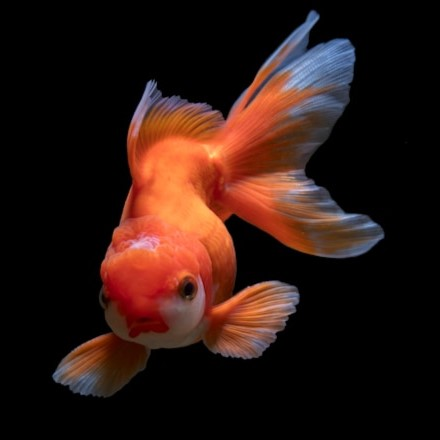

In [1]:
#Имя входного файла
input_file_name = 'images/fish.jpg'

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

#Импорты необходимых модулей
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
from pathlib import Path

# Загружаем изображение
img_path = Path(input_file_name).resolve()
print("Исходное изображение - фото золотой рыбки")
display(Image(filename = img_path))

### Препроцессинг изображения

tf.keras.applications.vgg16.preprocess_input() изменяет диапазон значений пикселей, вычитая средние значения каналов (RGB: [123.68, 116.779, 103.939])

Для корректного отображения изображения перед вызовом plt.imshow() денормализуем значения в диапазон [0,1], добавляя соответствующие средние значение каналов, с учетом использования tensorflow модели BGR вместо RGB


Изображение после препроцессинга


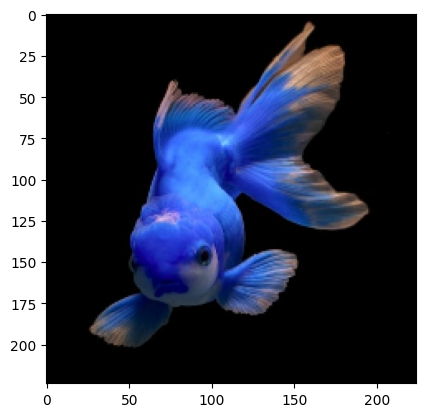

In [2]:
#Загружаем изображение и производим препроцессинг
img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_tensor = keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = tf.keras.applications.vgg16.preprocess_input(img_tensor)

print("Изображение после препроцессинга")
plt.imshow((img_tensor[0] + [103.939, 116.779, 123.68]).astype(np.uint8))  
plt.show()

### Продемонстрируем визуализацию каналов активации слоя block1_conv1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Форма слоя block1_conv1
(1, 224, 224, 64)

54 канал активации первого слоя


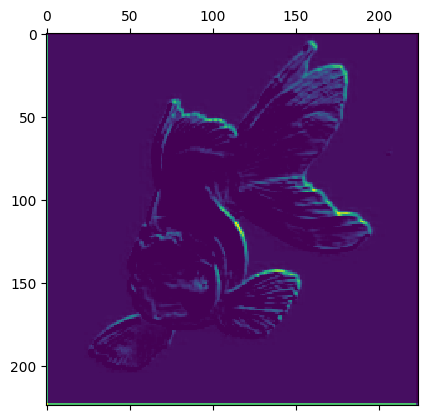

In [3]:
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
layer_outputs = [layer.output for layer in model.layers[1:9]]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print("Форма слоя", model.layers[1].name)
print(first_layer_activation.shape)
print()

print("54 канал активации первого слоя")
plt.matshow(first_layer_activation[0, :, :, 54], cmap='viridis')
plt.show()

### Составим карту признаков
 Составляем карту признаков, не считая input_layer (на нем 3 канала изначального изображения)</br>
 Карты признаков с block1_conv1 по block3_conv2

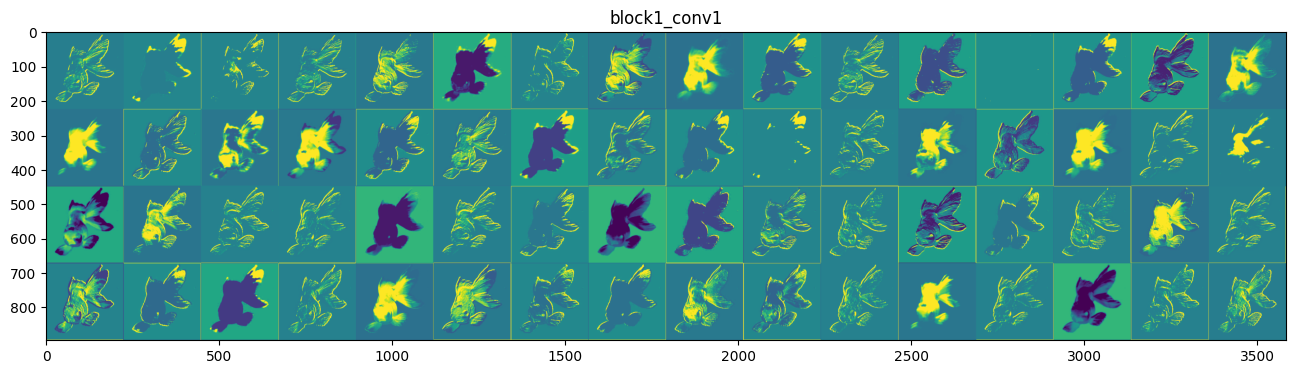

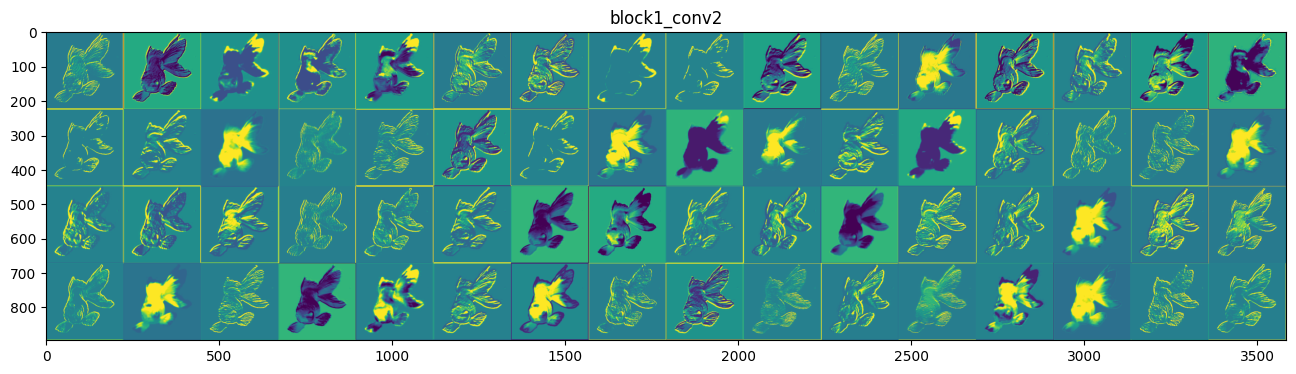

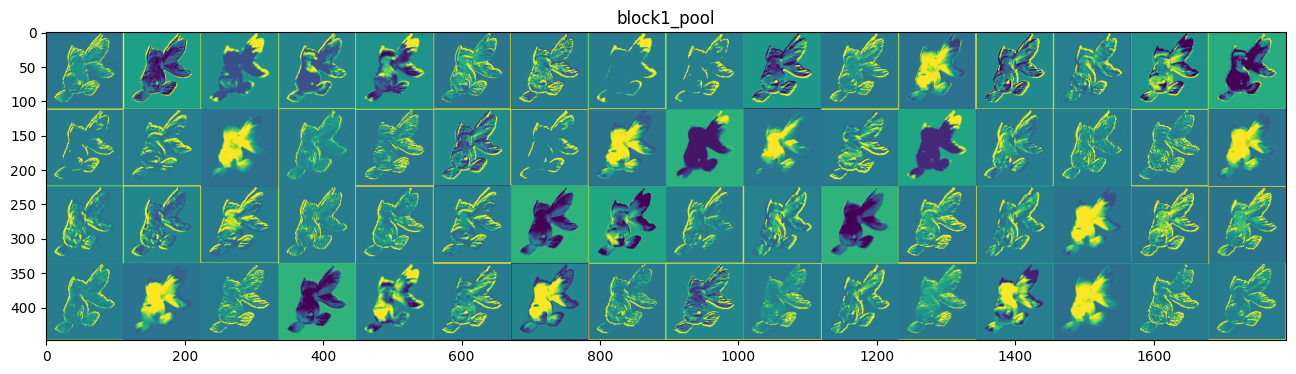

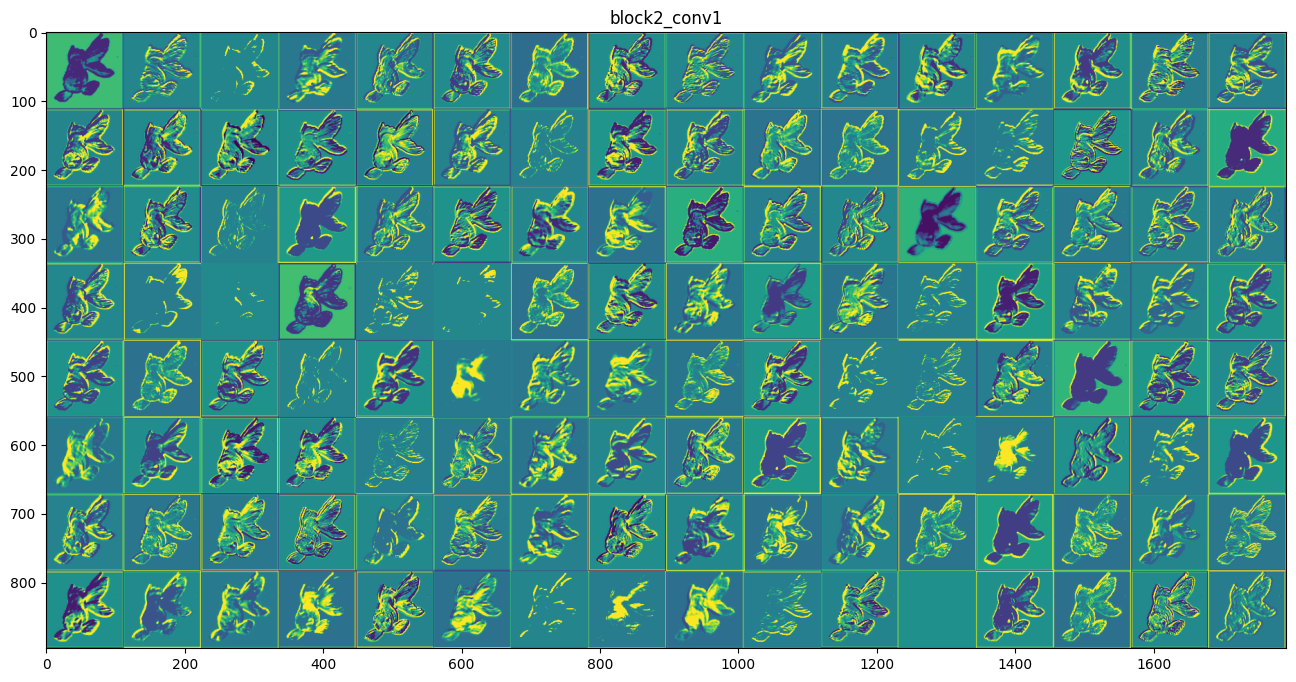

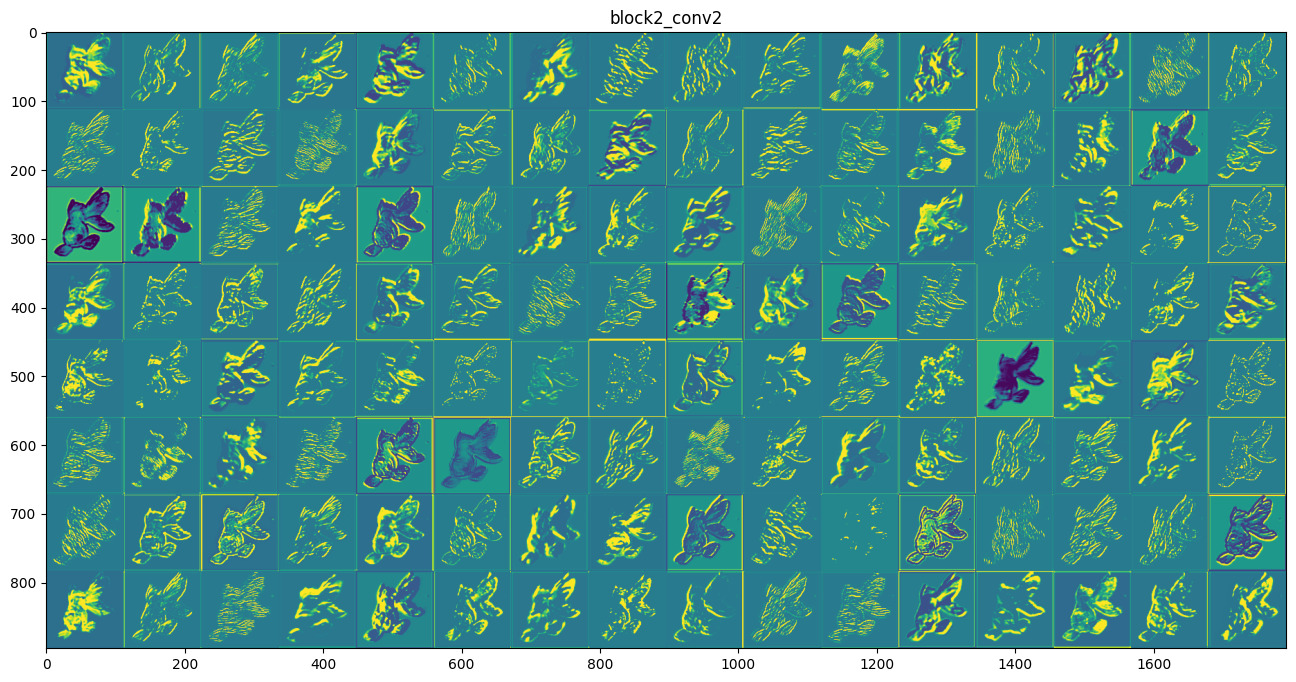

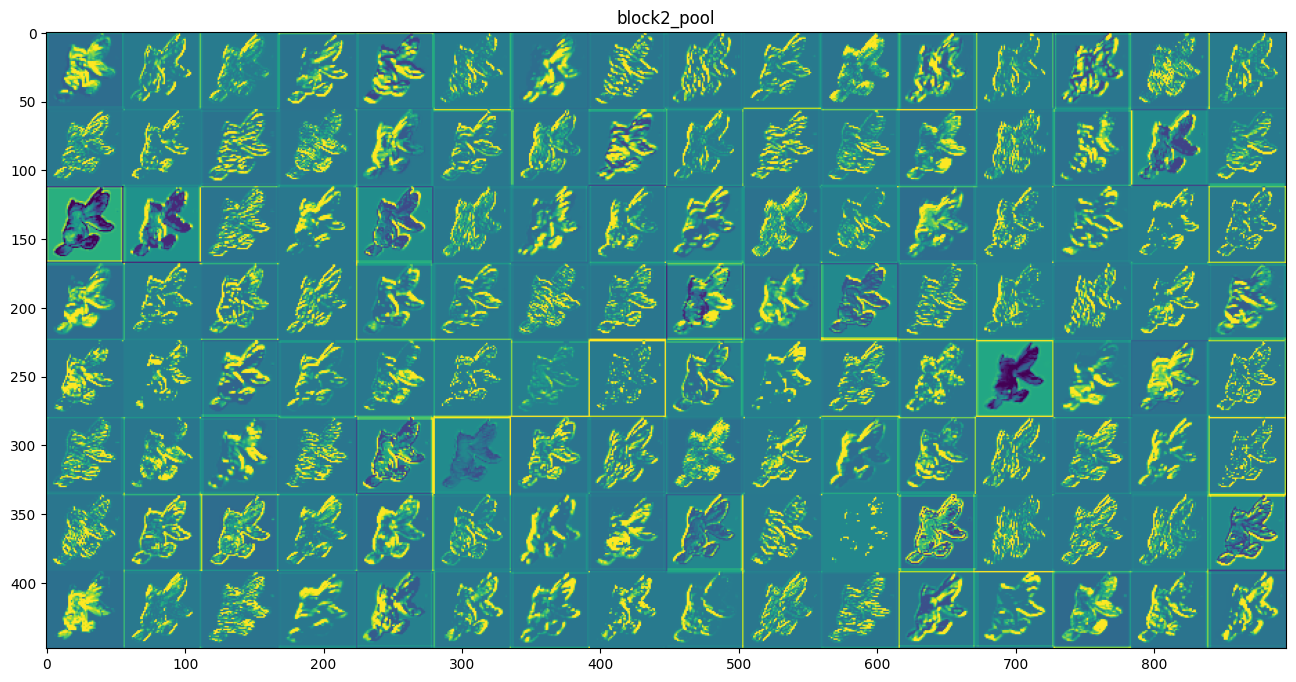

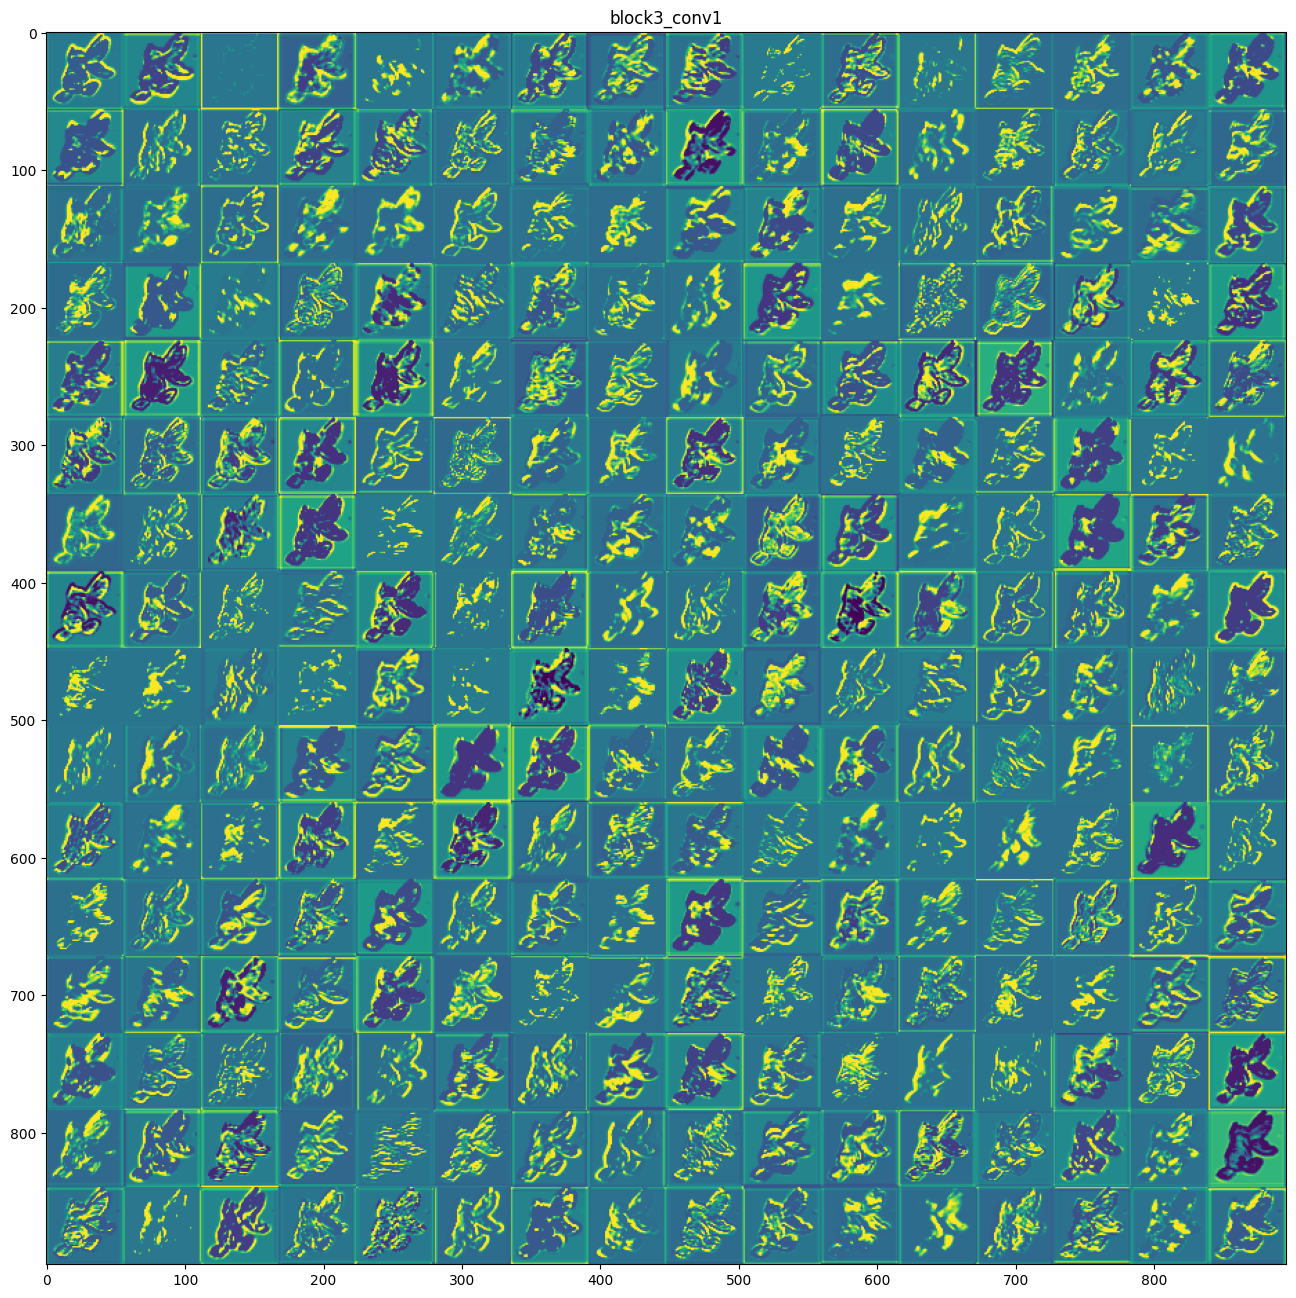

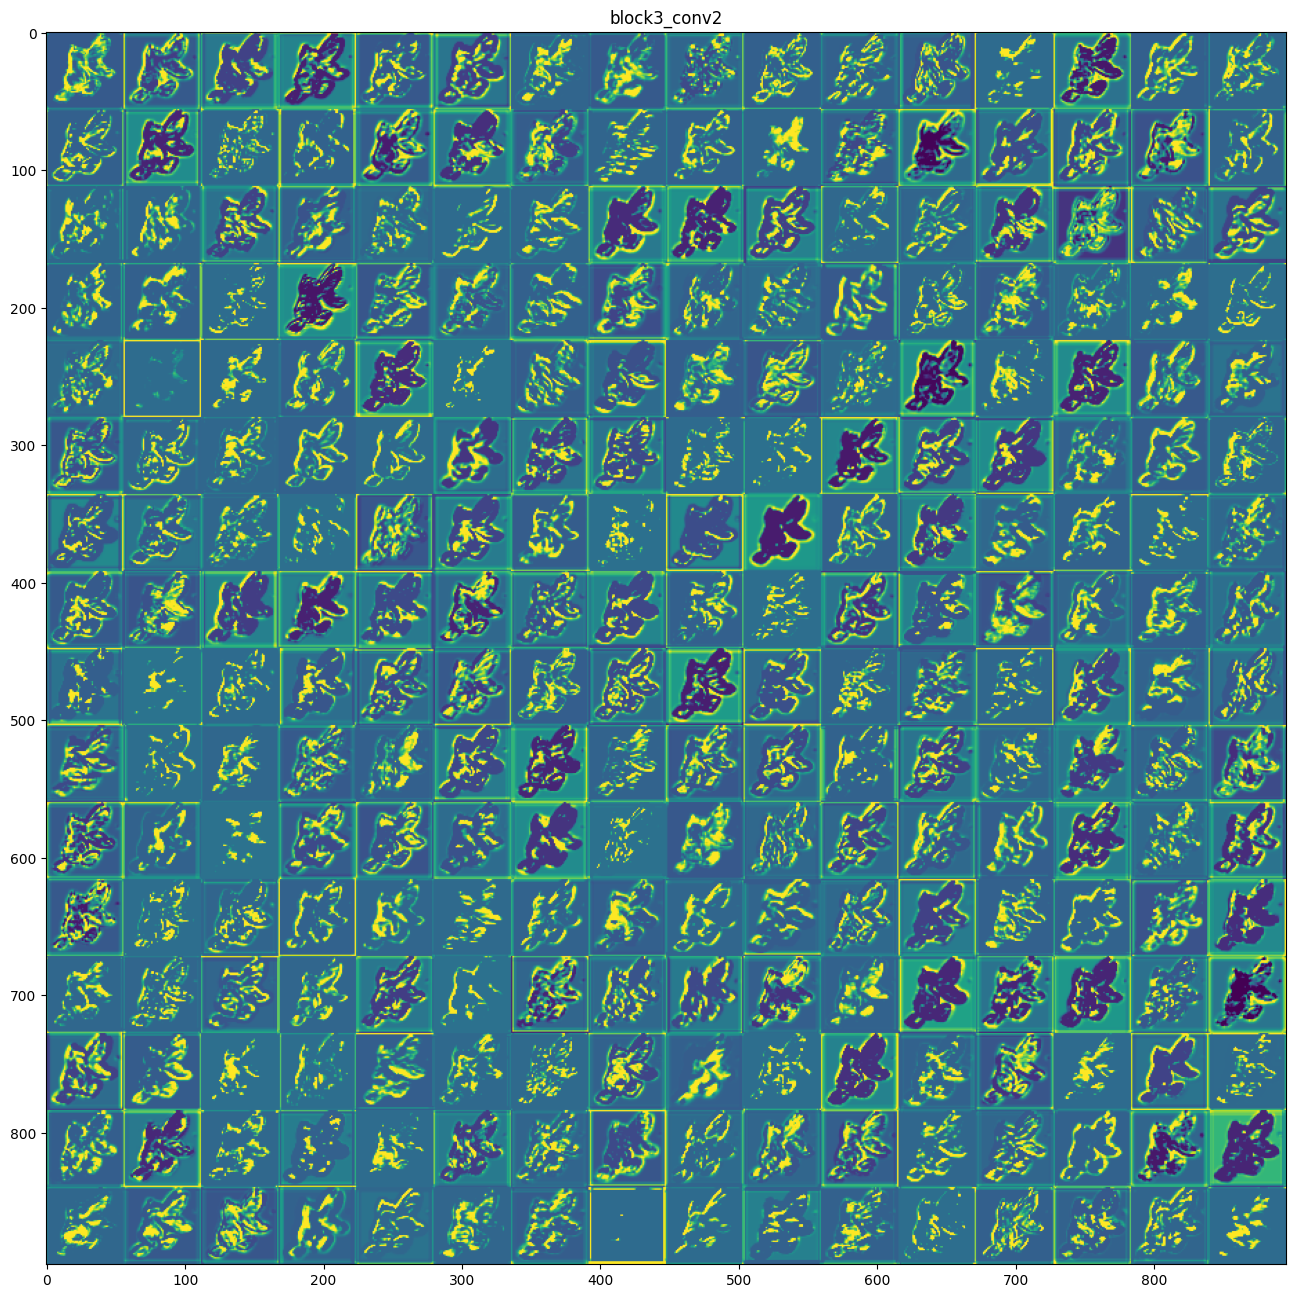

In [4]:
layer_names = []
for layer in model.layers[1:14]:
    layer_names.append(layer.name)
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= (channel_image.std() + 1e-5)
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
plt.show()